In [1]:
# Import essential libraries for data processing, visualization,
# model building, and evaluation (multi-output classification scenario)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
# Load tactical football dataset
df = pd.read_csv("football_tactical.csv")

# Preview first rows to understand structure
df.head()

,match_id,home_team,away_team,home_elo,away_elo,elo_diff,home_form5,away_form5,form_diff,home_avg_goals,...,home_shots_avg,away_shots_avg,opponent_style_home,opponent_style_away,home_strategy_used,away_strategy_used,home_formation_used,away_formation_used,result,goal_diff
0,0,Team_9,Team_8,1502,1835,-333,12,14,-2,2.18,...,14.42,15.91,Attacking,Attacking,Low Block,High Press,5-3-2,4-3-3,Away Win,1.41
1,1,Team_4,Team_18,1708,1743,-35,11,13,-2,0.99,...,10.08,14.57,Defensive,Defensive,Balanced,Balanced,4-2-3-1,4-2-3-1,Away Win,-0.03
2,2,Team_2,Team_1,1875,1589,286,13,14,-1,1.92,...,12.31,6.19,Attacking,Possession,High Press,Low Block,4-3-3,5-3-2,Home Win,0.63
3,3,Team_8,Team_17,1715,1413,302,1,9,-8,1.20,...,6.48,18.73,Attacking,Defensive,High Press,Low Block,4-3-3,5-3-2,Home Win,-0.05
4,4,Team_18,Team_14,1961,1787,174,1,13,-12,1.70,...,18.53,14.37,Attacking,Defensive,High Press,Low Block,4-3-3,5-3-2,Home Win,-0.45


In [3]:
# Inspect dataset structure (data types & missing values)
print(df.info())

# Generate statistical summary for numerical features
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   match_id             10000 non-null  int64  
 1   home_team            10000 non-null  object 
 2   away_team            10000 non-null  object 
 3   home_elo             10000 non-null  int64  
 4   away_elo             10000 non-null  int64  
 5   elo_diff             10000 non-null  int64  
 6   home_form5           10000 non-null  int64  
 7   away_form5           10000 non-null  int64  
 8   form_diff            10000 non-null  int64  
 9   home_avg_goals       10000 non-null  float64
 10  away_avg_goals       10000 non-null  float64
 11  home_avg_conceded    10000 non-null  float64
 12  away_avg_conceded    10000 non-null  float64
 13  home_possession_avg  10000 non-null  float64
 14  away_possession_avg  10000 non-null  float64
 15  home_shots_avg       10000 non-null  

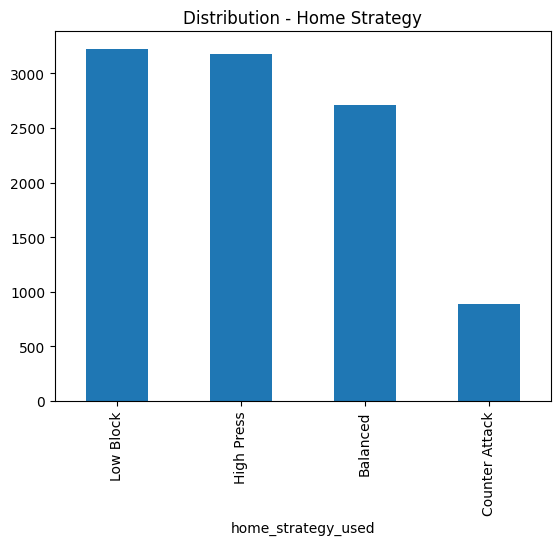

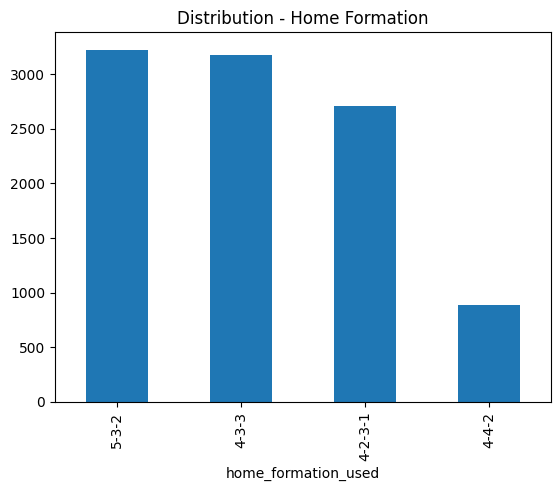

In [4]:
# Visualize distribution of home team strategies
plt.figure()
df['home_strategy_used'].value_counts().plot(kind='bar')
plt.title("Distribution - Home Strategy")
plt.show()

# Visualize distribution of home team formations
plt.figure()
df['home_formation_used'].value_counts().plot(kind='bar')
plt.title("Distribution - Home Formation")
plt.show()

In [5]:
# Apply one-hot encoding to categorical opponent style features
df = pd.get_dummies(df, columns=['opponent_style_home', 'opponent_style_away'])

# Define multi-output target columns
target_columns = [
    'home_strategy_used',
    'away_strategy_used',
    'home_formation_used',
    'away_formation_used'
]

# Encode target variables into numeric labels
label_encoders = {}
for col in target_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Encode team names into numerical representation
df['home_team'] = LabelEncoder().fit_transform(df['home_team'])
df['away_team'] = LabelEncoder().fit_transform(df['away_team'])

# Remove irrelevant column for modeling
df = df.drop(columns=['result'])

In [6]:
# Separate features (X) and multi-output targets (y)
X = df.drop(columns=target_columns)
y = df[target_columns]

# Split dataset into training and testing sets (80:20 ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

Train Shape: (8000, 26)
Test Shape: (2000, 26)


In [7]:
# Initialize base Random Forest model
base_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Wrap base model into MultiOutputClassifier
# to handle multiple tactical predictions simultaneously
model = MultiOutputClassifier(base_model)

In [8]:
# Train model on training data
model.fit(X_train, y_train)

# Generate predictions on test set
y_pred = model.predict(X_test)

MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=300,
                                                       n_jobs=-1,
                                                       random_state=42))

In [10]:
# Evaluate each output target independently
for i, col in enumerate(target_columns):
    print(f"\n===== Evaluation for {col} =====")
    acc = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    print("Accuracy:", acc)
    print(classification_report(
        y_test.iloc[:, i],
        y_pred[:, i]
    ))


===== Evaluation for home_strategy_used =====
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       543
           1       1.00      1.00      1.00       169
           2       1.00      1.00      1.00       616
           3       1.00      1.00      1.00       672

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


===== Evaluation for away_strategy_used =====
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       545
           1       1.00      1.00      1.00       167
           2       1.00      1.00      1.00       672
           3       1.00      1.00      1.00       616

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


===== E

In [11]:
# Extract feature importance from first target estimator
importances = model.estimators_[0].feature_importances_
features = X.columns

# Rank features by importance
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(10))

                           Feature  Importance
5                         elo_diff    0.554018
3                         home_elo    0.133749
4                         away_elo    0.129269
18   opponent_style_home_Attacking    0.082716
21  opponent_style_home_Possession    0.011433
20   opponent_style_home_Defensive    0.011385
19     opponent_style_home_Counter    0.011121
15                  home_shots_avg    0.005410
0                         match_id    0.005389
16                  away_shots_avg    0.005124


In [12]:
# Select one sample input from test set
sample_input = X_test.iloc[0:1]

# Generate tactical recommendation
prediction = model.predict(sample_input)

# Decode predicted labels back to original tactical names
decoded_prediction = {}
for i, col in enumerate(target_columns):
    decoded_prediction[col] = label_encoders[col].inverse_transform(
        [prediction[0][i]]
    )[0]

# Display final recommendation output
print("\n===== MATCH RECOMMENDATION =====")
for k, v in decoded_prediction.items():
    print(k, ":", v)


===== MATCH RECOMMENDATION =====
home_strategy_used : Low Block
away_strategy_used : High Press
home_formation_used : 5-3-2
away_formation_used : 4-3-3
